# Final Project: Tailoring Tinder Profiles According to Age
## IST-652 Section 21980
## Joseph Hartman

In [1]:
# Packages needed
import numpy as np
import pylab
import pandas as pd 
import nltk
import re
import matplotlib.pyplot as plt
import random
from textblob import TextBlob

%matplotlib inline

### Business Case

"The convenience of online dating allows for a person's dream of finding love to be crushed more effectively" -sommeecards user

Dating is hard. Dating is extremely hard. Despite being in an age where dating apps give us the ability to connect with hundreds if not thousands of prospective partners, finding "the one" has never seemed liked such an insurmountable task. Thus, in order to hopefully gleam a better glance at understanding the dating app world, this project is analyzing the [Tinder Profiles](https://www.kaggle.com/immune/tinder-female-profiles) dataset which gives us the name, biography text, and birthday of female tinder users. Our main objective is to find characteristics of a profile's biography such that other users can tailor their own biographies for a given age or age range.

Dataset: https://www.kaggle.com/immune/tinder-female-profiles

## Analysis Questions
1. When targeting a particular age or age demographic to date can we determine the ideal biography size and sentiment?
2. By creating a Naive-Bayes Classifier, can we extract the important words/features that show up depending on the age group of the user so that other users can tailor their biography using similar words to increase right-swiping potential?

### Data Preprocessing

One of the major challenges with this project was data processing and cleaning. Unlike structured csv files or even semi structured JSONs, the data file from Kaggle is unfortunately a mess of brackets, numbers, emojis, and characters. At first glance, there seems to be a clear structure to the data as all the information that is needed is found between the square brackets. Unfortunately, there is no clear split between lines of data. Regular expressions can't be used to parse the data due to the emoticons and other parsers from packages failed to produce desired results. Thus, parsing the data was done entirely from scratch. Also, a huge of chunk of the text file was removed that did not contain biography text or birth year prior to the file being read.

In [2]:
# Reads the text file in and closes the file
file = open('tinder_bios.txt', 'r', encoding="utf-8")
textblock = file.read()
file.close()
print("Head of tinder_bios.txt")
print(textblock[:1000])

Head of tinder_bios.txt
﻿
Liked 52c10843d04f42de530009d1 [ Alex ] [I wanna meet other creative brains and artists.
Drawing. Hiking. Music. Gluten free Food.  Community. Reading. Poodles give me life. 👍🏽😁 if you like  skateboards. 🌈✨🌈] 
Liked 5b5693d5938c214d3cb62e0f [ Dyn ] [Zhang dyrin
] Liked 5a98871bd700513e3905c1ea [ Meagan ] [CO raised CA livin💃🏽🏝
] Liked 5b50ee72be4664780567bd80 [ V ]
 [  ] Liked 5b5972073888e64e1d60c810 [ Mason ] [  ] 
Liked 5a94d2b4108f729a0c65b601 [ Mindy ] [Directionally challenged
] Liked 5b59761f4c19f8291d8da633 [ Daisy ] [I like the zoo and tacos. I’m looking for someone to help me steal a meerkat. Serious inquires only.
] Liked 5b5123a9696d2e8105d88aba [ Karoline ] [Croatian 🇭🇷
] Liked 5b5980639ace37f11d7fcdb2 [ Latína ] [What is there to know about me... 🤔
I love food & I’m weird. I love traveling. Music is one of my passions along with dancing. 
Oh & of course I love food. 
Young heart but old soul...
] Liked 5b59a72b3888e64e1d60f504 [ Eff ] [Queer fem 

One common feature that each line starts with is the word, "Liked", followed by the number 5 and a string of other numbers, possibly an ID for a database. Using `split` with "Liked 5" produced the ideal segmentation of the data. From there, a function was built to find the text within the brackets and store them as a list, which was then run on each line to produce a list of lists. This structure is something that can be more easily stored in to a `pandas` data frame.

Since complete data entries/rows are useful for analysis, any line/entry where there was no text where the biography might be written is removed before entry into the data frame.

In [3]:
# Splits the text file where the line "Liked 5" appears
tinderlines = textblock.split("Liked 5")
# Cleans the data a little bit
tinderlines = [line.replace("\n", "") for line in tinderlines]
# Removes the first line as it has no relevant information
tinderlines = tinderlines[1:]
# Shows how many lines there are
print("There are",len(tinderlines), "entries.")

There are 60332 entries.


In [4]:
# This function will be used on each line to find the information
# in the brackets. Basically, it looks for each bracket, then stores
# whatever is in the brackets as a list
def extract(line):
    start1 = line.find('[') + 1
    end1 = line.find(']')
    start2 = line.find('[', end1) + 1
    end2 = line.find(']', start2)
    start3 = line.find('[', end2) + 1
    end3 = line.find(']', start3)
    if line[start3] == " ":
        return([line[start1+1:end1-1], 
                line[start2+1:end2-1], 
                line[start3+1:end3-15]])

In [5]:
# Runs our "extract" function to compile a list of lists of tinder bio data
# then removes any list where the biography is empty and the first line
# Finally it prints the first five results
tinderlists = [extract(line) for line in tinderlines if extract(line) != None]
tinderlists = tinderlists[1:]
tinderlists = [item for item in tinderlists if item[1] != '']
print("There are", len(tinderlists), "complete entries.")
print()
print("First 5 complete entries")
print()
for i in tinderlists[:5]:
    print(i)

There are 43639 complete entries.

First 5 complete entries

['Kelly', '😁', '1995-07-29']
['Rachel', 'you win some, you dim sum my favorite pastimes: rewatching Westworld, collecting Stitch items, playing the piano, drinking boba, and going on food adventures!outgoing and sarcastic as hell UCLA | San DiegoTell me your best dad joke :p', '1997-07-29']
['Victoria', 'Jeg elsker at bruge massere af smileyer ✌️\U0001f929☺️😊😇🤗😉😀😆', '1992-07-29']
['Natasha', 'scorpio♏️🇧🇩', '1997-07-29']
['Jade', '5’2” on a good day', '1995-07-29']


Moving the list of lists into a data frame was simple (`DataFrame` can be surpisingly flexible). After which, some new calculated columns were added like the age of the user, the number of words/tokens they use, and the sentiments of each of their sentences. Finally, the data has been sufficiently transformed from which analysis can be done.

In [6]:
# reads lists into a dataframe, renames columns, and changes the birthday object into a timestamp
tinderdf = pd.DataFrame(tinderlists)
tinderdf.columns = ['name', 'bio', 'birthday']
tinderdf['birthday'] = pd.to_datetime(tinderdf['birthday'])
# creates an age column by creating a timedelta object(given in days),divided by 365, rounded, then converted to an integer
tinderdf['age'] = round(((pd.to_datetime('today') - tinderdf['birthday']).dt.days)/365)
tinderdf['age'] = pd.to_numeric(tinderdf['age'], downcast = "integer")

# Turns everything to lowercase
tinderdf['bio'] = tinderdf['bio'].str.lower()

# Removes stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
tinderdf['bio'] = tinderdf['bio'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# takes in only characters and spaces
tinderdf["bio"] = tinderdf['bio'].str.replace('[^\w\s]','')

# tokenizes using tweet tokenizer and counts the tokens in each biography
ttokenizer = nltk.tokenize.TweetTokenizer()
tinderdf['unigrams'] = tinderdf['bio'].apply(ttokenizer.tokenize)
tinderdf['unigram_count'] = tinderdf['unigrams'].apply(len)

# adds new columns that score sentiment 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
tinderdf['neg_score'] = tinderdf['bio'].apply(lambda x: sid.polarity_scores(x)['neg'])
tinderdf['neu_score'] = tinderdf['bio'].apply(lambda x: sid.polarity_scores(x)['neu'])
tinderdf['pos_score'] = tinderdf['bio'].apply(lambda x: sid.polarity_scores(x)['pos'])

# returns the first 10 lines of the dataframe
# print(tinderdf.dtypes) check datatypes but not necessary to run
tinderdf.head(10)

,name,bio,birthday,age,unigrams,unigram_count,neg_score,neu_score,pos_score
0,Kelly,,1995-07-29,24,[],0,0.000,0.000,0.000
1,Rachel,win some dim sum favorite pastimes rewatching ...,1997-07-29,22,"[win, some, dim, sum, favorite, pastimes, rewa...",27,0.163,0.468,0.369
2,Victoria,jeg elsker bruge massere af smileyer,1992-07-29,27,"[jeg, elsker, bruge, massere, af, smileyer]",6,0.000,1.000,0.000
3,Natasha,scorpio,1997-07-29,22,[scorpio],1,0.000,1.000,0.000
4,Jade,52 good day,1995-07-29,24,"[52, good, day]",3,0.000,0.408,0.592
5,Jackie,raves raves raves,1993-07-29,26,"[raves, raves, raves]",3,0.000,1.000,0.000
6,Kathrine,im funny outgoing sassy sweet love traveling v...,1991-07-29,28,"[im, funny, outgoing, sassy, sweet, love, trav...",40,0.000,0.569,0.431
7,Shawna,twentysomething registered nurse 313 constantl...,1989-07-29,30,"[twentysomething, registered, nurse, 313, cons...",12,0.000,0.617,0.383
8,Katelyn,im meet dog catsnapchat katie_kate18 lemme kn...,1999-07-29,20,"[im, meet, dog, catsnapchat, katie_kate, 18, l...",14,0.086,0.728,0.185
9,Ce,gusta la pizza lo único que busco aquí son bue...,1999-07-29,20,"[gusta, la, pizza, lo, único, que, busco, aquí...",11,0.000,1.000,0.000


### Analysis

There are multiple problems that might interfere with our analysis when looking at the first few rows of the data frame:

* It is clear that Tinder is used worldwide. The user, Victoria, speaks Norwegian, while the user, Ce, speaks Spanish. NLTK's processing tools were designed for the English language meaning that any sort of stop word removal was done only for English users. This also likely means that these foreign users aren't likely to contribute anything useful to the analysis or the classification model that is built further in the report.


* The sentence processing removed some punctuation that is somewhat important. From personal experience, I can say that many users tend to report their height. In this case, the occurrence that Jade reported her height as 5'2", has been misrepresented as 52.


* All of the emoticons have been removed. This is a problem as emoticons are used in text as shorthand to convey interests, values, and personality. Thus, our sentiment scores may not be that accurate if they aren't taken into account.

However, for the purposes of this project, only tools within the NLTK toolset are going to be used.

#### Analysis Question 1: When targeting a particular age or age demographic to date can we determine the ideal biography size and sentiment?

By looking at the graphs below, which were created with `pandas`'s built in `groupby` and `plot` functions, most of the users are under the age of 30, with half of the users at the age of 25 and below. 


There is a trend in the following graph, "Number of Unigrams vs. User Age", where there is a positive trend between a user's age and the number of unigrams they use. Under the age of 25, users tend to use around 15 or less unigrams while users above use more. When we get to the upper echelons of age in our dataset, those in their late 30s to 40 tend to use 20 or more unigrams.


In terms of sentiment, there does seem to be a slight increase in positive sentiment and decrease in negative sentiment as age increases. However, as pointed above, this does not take in to account the use of emoticons or slang, which might be used more frequently by those on the lower end of the age spectrum. Thus, I do not believe that using the tools and techniques above we can find an ideal sentiment of a biography for a given age.

Text(0.5, 0, 'Age in Years')

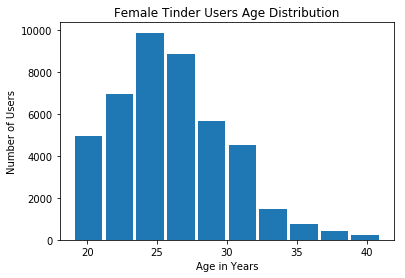

In [7]:
# Builds a histogram showing distribution of ages
tinderdf['age'].plot.hist(bins = 10, rwidth = 0.9)
plt.title('Female Tinder Users Age Distribution')
plt.ylabel('Number of Users')
plt.xlabel('Age in Years')

Trendline Equation: y=0.478261x+(1.913043)


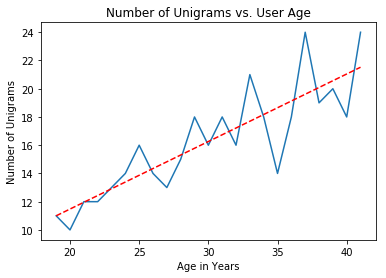

In [8]:
# Plots number of unigrams used vs user's age
wordsvsuser = round(tinderdf.groupby('age')['unigram_count'].mean())
wordsvsuser.plot()
plt.title('Number of Unigrams vs. User Age')
plt.ylabel('Number of Unigrams')
plt.xlabel('Age in Years')

# Calculates the trendline
x = wordsvsuser.index
y = wordsvsuser.values
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
pylab.plot(x,p(x),"r--")
# Prints the line equation:
print("Trendline Equation:","y=%.6fx+(%.6f)"%(z[0],z[1]))

Text(0.5, 0, 'Age in Years')

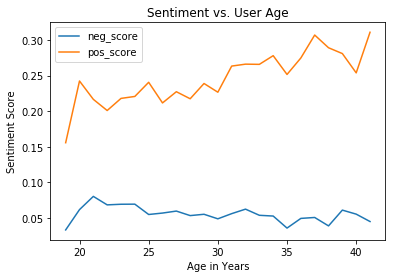

In [9]:
# Plots overall sentiment of user's bio vs user's age
tinderdf.groupby('age')['neg_score', 'pos_score'].mean().plot()
plt.title('Sentiment vs. User Age')
plt.ylabel('Sentiment Score')
plt.xlabel('Age in Years')

#### Analysis Question 2: By creating a Naive-Bayes Classifier, can we extract the important words/features that show up depending on the age group of the user so that other users can tailor their biography using similar words to increase right-swiping potential?

For this project, an arbitrary age was chosen as the split point to create a boolean variable. In this case, that age was 28. In order to get an idea of the common words used, NLTK's `FreqDist` function was used. After which, a `pandas` data frame was built showing the top 50 words and their frequencies for users that are designated as "young" (age < 25 years) or "old" ( age >= 25 years). 

At first glance, it does not seem that theres any discernable differences in patterns of the words that are used for each age group. The only real difference I could find was that the term "ig" or "IG", the abbreviation for Instagram, popped up for words that are used by those under 25.

In [10]:
# Breaks up "tinderdf" based on the age of the user
tinderyoung = tinderdf[tinderdf.age < 25]
tinderold = tinderdf[tinderdf.age >= 25]
# Combines all the words/tokens in each dataframe into a set of words then counts frequencies
wordsyoung = [word for words in tinderyoung['unigrams'] for word in words]
wordsold = [word for words in tinderold['unigrams'] for word in words]
youngfd = nltk.FreqDist(wordsyoung)
oldfd = nltk.FreqDist(wordsold)

# Divies up 1-25, 25-50 most common words and stores them into a dataframe
commonyoung1 = pd.DataFrame(youngfd.most_common(50)[:25])
commonold1 = pd.DataFrame(oldfd.most_common(50)[:25])
commonyoung2 = pd.DataFrame(youngfd.most_common(50)[25:])
commonold2 = pd.DataFrame(oldfd.most_common(50)[25:])
commonwords = pd.concat([commonyoung1, commonold1, commonyoung2, commonold2], axis=1)
commonwords.columns = ["words(<25)", "1-25", "words(>=25)", "1-25", "words(<25)", "25-50", "words(>=25)", "25-50"]
commonwords

,words(<25),1-25,words(>=25),1-25,words(<25),25-50,words(>=25),25-50
0,im,5331,im,9564,right,646,right,1304
1,love,2960,love,5851,ig,602,dog,1289
2,looking,2501,looking,4874,me,598,swipe,1276
3,like,2255,like,4366,take,592,going,1187
4,dont,1634,new,3148,meet,587,one,1142
5,know,1324,dont,2454,message,579,youre,1131
6,go,1184,good,2400,need,562,travel,1122
7,someone,1147,time,2370,ask,557,working,1082
8,new,1116,know,2314,really,557,also,1076
9,life,1062,someone,2251,talk,535,food,1051


##### Building a Naive Bayes Classification Model

Since NLTK's `FreqDist` failed to provide any real insight. A Naive Bayes classification model was built using TextBlob's `NaiveBayesClassifier` model. What's interesting about this approach to answering question 2 is not that the goal of building this model is not to predict a user's age group based of the words the model is given, but to look at the informative features of the model that is trained. This can be easily done in TextBlob using `show_informative_features`. By looking at these informative features, hopefully, discernable features between "young" and "old" users can be made.

Textblob takes in a list of tuples as its input for its classification model so a list of tuples taking the biographies and "old/young" Boolean is made using `zip`. After which, it is shuffled. Due to the extensive size of the full set of data, in order to make the model manageable to run on home PCs to showcase this approach, only 5000 out of 43639 rows were selected. The data was then split into training and testing datasets using an 80/20 split respectively. From this the model was trained, checked for accuracy using a variety of measures (overall accuracy, confusion matrix, precision, recall, F-score), and the informative features were printed out.

In [15]:
# Creates a boolean column where users over 25 are "old" and 25 and under is "young"
tinderdf['old/young'] = np.where(tinderdf['age']<25, 'young', 'old')
# creates a list of tuples which is then converted back into strings to be split into train and test datasets
traintest = zip(tinderdf['bio'], tinderdf['old/young'])
traintest = list(traintest)
# Shuffles the tuples in the traintest set
random.shuffle(traintest)

# In order to demonstrate the model and capabilities, we'll sample 5000 items from the traintest set
# as trying to use the whole set results in a memory error
indices = random.sample(range(len(traintest)), 5000)
traintestsample = [traintest[item] for item in sorted(indices)]

# Builds the training and testing data (80/20 split) and prints out how long each is, 
trainset, testset = traintestsample[:round(len(traintestsample)*.8)], traintestsample[round(len(traintestsample)*.8):]
print("Length of training set is", len(trainset))
print("Length of testing set is",len(testset))

Length of training set is 4000
Length of testing set is 1000


In [16]:
# Training the classifier
from textblob.classifiers import NaiveBayesClassifier
youthcl= NaiveBayesClassifier(trainset)

In [17]:
# Tests and prints out the accuracy of the model
print("Model Accuracy:", youthcl.accuracy(testset))
print()

# Builds two lists that contain the predicted and correct results and builds a confusion matrix
goldlist = [tup[1] for tup in testset]
predictedlist = [youthcl.classify(tup[0]) for tup in testset]
cm = nltk.ConfusionMatrix(goldlist, predictedlist)
print(cm.pretty_format(sort_by_count=True, truncate=9))
print()

# Code taken from IST-664: Natural Language Processing under Professor Nancy McCraken
# Function to compute precision, recall and F1 for each label
#  and for any number of labels
# Input: list of gold labels, list of predicted labels (in same order)
# Output:  prints precision, recall and F1 for each label
def eval_measures(gold, predicted):
    # get a list of labels
    labels = list(set(gold))
    # these lists have values for each label 
    recall_list = []
    precision_list = []
    F1_list = []
    for lab in labels:
        # for each label, compare gold and predicted lists and compute values
        TP = FP = FN = TN = 0
        for i, val in enumerate(gold):
            if val == lab and predicted[i] == lab:  TP += 1
            if val == lab and predicted[i] != lab:  FN += 1
            if val != lab and predicted[i] == lab:  FP += 1
            if val != lab and predicted[i] != lab:  TN += 1
        # use these to compute recall, precision, F1
        recall = TP / (TP + FP)
        precision = TP / (TP + FN)
        recall_list.append(recall)
        precision_list.append(precision)
        F1_list.append( 2 * (recall * precision) / (recall + precision))

    # the evaluation measures in a table with one row per label
    print('\tPrecision\tRecall\t\tF1')
    # print measures for each label
    for i, lab in enumerate(labels):
        print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
          "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))

print(eval_measures(goldlist, predictedlist))

Model Accuracy: 0.712

      |       y |
      |       o |
      |   o   u |
      |   l   n |
      |   d   g |
------+---------+
  old |<446>165 |
young | 123<266>|
------+---------+
(row = reference; col = test)


	Precision	Recall		F1
old 	      0.730      0.784      0.756
young 	      0.684      0.617      0.649
None


According to the hold-out test, the model performs extremely well with some bias towards "young". This is to be expected as there are more Tinder users under 25 then over 25 years of age. I admit, I was a little surprised at the performance of the model, expecting not just a lower level of overall accuracy but a much higher level of bias. Though, this level of accuracy is second to what the model thinks are the most informative features.

In [18]:
print(youthcl.show_informative_features(50))

Most Informative Features
        contains(needed) = True            young : old    =     15.9 : 1.0
         contains(dress) = True            young : old    =     15.9 : 1.0
        contains(zombie) = True            young : old    =     14.8 : 1.0
         contains(steak) = True            young : old    =     13.7 : 1.0
        contains(nothin) = True            young : old    =     13.7 : 1.0
        contains(dating) = True              old : young  =     13.6 : 1.0
          contains(will) = True            young : old    =     12.6 : 1.0
            contains(23) = True              old : young  =     12.0 : 1.0
            contains(20) = True            young : old    =     10.2 : 1.0
            contains(22) = True            young : old    =      9.6 : 1.0
       contains(biology) = True            young : old    =      9.3 : 1.0
         contains(pasta) = True            young : old    =      9.3 : 1.0
          contains(lame) = True            young : old    =      9.3 : 1.0

Results look pretty good!

### Overall Conclusions

3 main conclusions can be derived from our analysis:

1. Older users tend to have bigger biographies, thus if the target age range is over 25, add a little more detail about to increase perceived effort in terms finding a match. If not, keep biographies short and to the point to avoid distancing/boring potential matches.


2. Sentiment (use of positive or negative language) does not seem to have a noticeable impact except for maybe a slight effect in the "old" group. The effects will probably be minimal but try using more positive language than negative language.


3. Emoticons seem to be very popular amongst younger users. If targeting this group, use a combination of emoticons and very short, to the point bios for maximum effect. This is less of a conclusion drawn from analysis as more of an observation.


Analyzing Tinder profile data turned out to be much more challenging than expected. This is mainly due to the fact that current NLP and Text Mining technologies are built around proper English usage and grammar. In the world of online dating, most of these rules don't apply. Especially amongst younger users, slang, shorthand grammar, and emoticons are commonly used to communicate their interests, hobbies, values, and desires in a partner. A whole new lexicon of internet speak would need to be built in order to take on this sort of task.